In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np


In [2]:
# get market info for bitcoin from the start of 2016 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# look at the first few rows
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-03-31,6892.48,7207.85,6863.52,6973.53,4553270000,116820000000
1,2018-03-30,7171.45,7276.66,6683.93,6890.52,6289510000,121534000000
2,2018-03-29,7979.07,7994.33,7081.38,7165.70,6361230000,135205000000
3,2018-03-28,7836.83,8122.89,7809.17,7954.48,4935290000,132781000000
4,2018-03-27,8200.00,8232.78,7797.28,7833.04,5378250000,138919000000


In [6]:
# get market info for ethereum from the start of 2016 to the current day
eth_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
# look at the first few rows
eth_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-03-31,395.00,418.47,392.95,396.46,1323920000,38914900000
1,2018-03-30,385.90,409.93,368.63,394.64,1878130000,38010600000
2,2018-03-29,448.07,450.81,385.81,385.97,1970230000,44125000000
3,2018-03-28,450.29,466.21,444.86,446.28,1514180000,44334000000
4,2018-03-27,489.59,491.46,449.97,450.12,1617940000,48193300000


In [7]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func = "linear",
                dropout =0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))

    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [9]:
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]
eth_market_info.columns =[eth_market_info.columns[0]]+['eth_'+i for i in eth_market_info.columns[1:]]

In [10]:
market_info = pd.merge(bitcoin_market_info,eth_market_info, on=['Date'])
market_info = market_info[market_info['Date']>='2016-01-01']
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)
market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap,bt_day_diff,eth_day_diff
0,2018-03-31,6892.48,7207.85,6863.52,6973.53,4553270000,116820000000,395.00,418.47,392.95,396.46,1323920000,38914900000,0.011759,0.003696
1,2018-03-30,7171.45,7276.66,6683.93,6890.52,6289510000,121534000000,385.90,409.93,368.63,394.64,1878130000,38010600000,-0.039173,0.022648
2,2018-03-29,7979.07,7994.33,7081.38,7165.70,6361230000,135205000000,448.07,450.81,385.81,385.97,1970230000,44125000000,-0.101938,-0.138594
3,2018-03-28,7836.83,8122.89,7809.17,7954.48,4935290000,132781000000,450.29,466.21,444.86,446.28,1514180000,44334000000,0.015012,-0.008905
4,2018-03-27,8200.00,8232.78,7797.28,7833.04,5378250000,138919000000,489.59,491.46,449.97,450.12,1617940000,48193300000,-0.044751,-0.080618


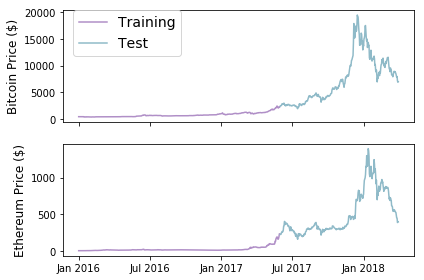

In [15]:
split_date = '2017-06-01'
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
#ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['bt_Close'], 
         color='#B08FC7', label='Training')
ax1.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['bt_Close'], 
         color='#8FBAC8', label='Test')
ax2.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['eth_Close'], 
         color='#B08FC7')
ax2.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['eth_Close'], color='#8FBAC8')
ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

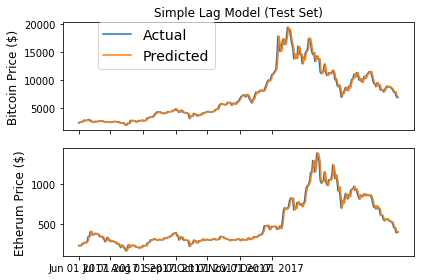

In [16]:
# trivial lag model: P_t = P_(t-1)
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['bt_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['bt_Close'][1:].values, label='Predicted')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.set_title('Simple Lag Model (Test Set)')
ax2.set_ylabel('Etherum Price ($)',fontsize=12)
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['eth_Close'][1:].values, label='Predicted')
fig.tight_layout()
plt.show()

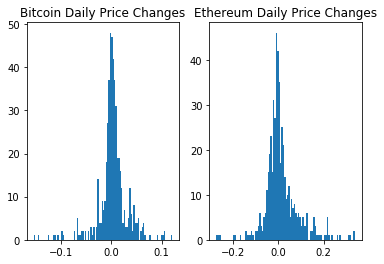

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(market_info[market_info['Date']< split_date]['bt_day_diff'].values, bins=100)
ax2.hist(market_info[market_info['Date']< split_date]['eth_day_diff'].values, bins=100)
ax1.set_title('Bitcoin Daily Price Changes')
ax2.set_title('Ethereum Daily Price Changes')
plt.show()

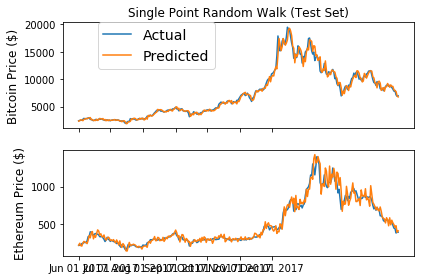

In [18]:
np.random.seed(202)
bt_r_walk_mean, bt_r_walk_sd = np.mean(market_info[market_info['Date']< split_date]['bt_day_diff'].values), \
                         np.std(market_info[market_info['Date']< split_date]['bt_day_diff'].values)
bt_random_steps = np.random.normal(bt_r_walk_mean, bt_r_walk_sd, 
                (max(market_info['Date']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)
eth_r_walk_mean, eth_r_walk_sd = np.mean(market_info[market_info['Date']< split_date]['eth_day_diff'].values), \
                         np.std(market_info[market_info['Date']< split_date]['eth_day_diff'].values)
eth_random_steps = np.random.normal(eth_r_walk_mean, eth_r_walk_sd, 
                (max(market_info['Date']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
     market_info[market_info['Date']>= split_date]['bt_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
      market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['bt_Close'].values[1:] * 
     (1+bt_random_steps), label='Predicted')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
     market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
      market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['eth_Close'].values[1:] * 
     (1+eth_random_steps), label='Predicted')
ax1.set_title('Single Point Random Walk (Test Set)')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.tight_layout()
plt.show()